In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Create model

In [2]:
from pypoptim.model import CardiacModel

In [3]:
dirname = '/home/andrey/WORK/HPL/Code/pypoptim/src/model_ctypes/_koivumaki'
filename_so = os.path.join(dirname, 'koivumaki.so')

koivumaki = CardiacModel(filename_so)

# Parse config

In [4]:
from pypoptim.helpers import strip_comments, random_value_from_bounds
import json

In [5]:
from gene_utils import create_genes_dict_from_config, \
                       create_constants_dict_from_config, \
                       generate_bounds_gammas_mask_multipliers

from io_utils import prepare_config

In [6]:
config_filename = "../../configs/koivumaki/10kHz_gKb/config_G2C1_test.json"

config = prepare_config(config_filename)

In [7]:
genes_dict = create_genes_dict_from_config(config)
state = config['runtime']['states_initial']
genes_m_index = config['runtime']['m_index']
    
genes = [random_value_from_bounds(gene_params['bounds'], log_scale=gene_params['is_multiplier'])
         if gene_name not in state.index else state[exp_cond_name][gene_name]
         for exp_cond_name, exp_cond in genes_dict.items() for gene_name, gene_params in exp_cond.items()]

genes = pd.Series(data=genes, index=genes_m_index)
genes['common'] = 1.

In [8]:
from gene_utils import update_S_C_from_genes, \
                       update_genes_from_state

from model_utils import calculate_n_samples_per_stim

In [9]:
model = CardiacModel(filename_so)

In [10]:
from solmodel import SolModel, calculate_loss

SolModel.model = model
SolModel.config = config

In [11]:
genes

ec_name  g_name         
common   STIM_LEVEL           1.000000
         PNa                  1.000000
         gCaL                 1.000000
         gt                   1.000000
         gKur                 1.000000
         gK1                  1.000000
         gKr                  1.000000
         gKs                  1.000000
         INaKmax              1.000000
         ICaPmax              1.000000
         gIf                  1.000000
         kNaCa                1.000000
         Jrel_multiplier      1.000000
         cpumps               1.000000
         kSRleak              1.000000
         fluo_tot             1.000000
         gNab                 1.000000
         gCab                 1.000000
         gKb                  1.000000
2064     Nai                  8.771444
         Ki                 135.500175
         CaSR                 0.720163
1032     Nai                 10.319751
         Ki                 134.276020
         CaSR                 0.740165


In [13]:
x0 = genes.values.copy()
x0[1] = 1
sol = SolModel(x0, state=state.copy())

In [14]:
sol.update()
sol.y

113.35109176304917

In [15]:
sol['status']

2

In [16]:
sol.is_valid()

True

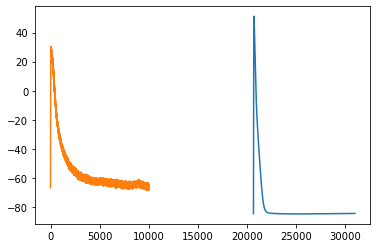

In [17]:
plt.plot(sol['phenotype']['1032'].V)
plt.plot(config['experimental_conditions']['1032']['phenotype'].V)

In [18]:
from pypoptim.algorythm.ga import GA

In [19]:
bounds = config['runtime']['bounds']
gammas = config['runtime']['gammas']
mask_multipliers = config['runtime']['mask_multipliers']

In [20]:
ga_optim = GA(SolModel, bounds, gammas, mask_multipliers,
              keys_data_transmit=['state'])

In [30]:
population = ga_optim.generate_population(1)
for sol in population:
    sol['state'] = state.copy()

In [31]:
sol.update()

In [32]:
ga_optim.update_population(population)

In [33]:
len(population)

1

In [34]:
population[0].x[0] = 1

In [35]:
ga_optim._is_solution_inside_bounds(population[0])

True

In [37]:
ga_optim._is_solution_inside_bounds(sol)

True

In [38]:
population = ga_optim.filter_population(population)
len(population)

1

In [39]:
from tqdm.auto import tqdm

In [40]:
n_solutions = 5
n_elites = 1
n_epochs = 10

population = ga_optim.generate_population(n_solutions)

for sol in population:
    sol['state'] = state.copy()

loss = []

for i in tqdm(range(n_epochs)):

    for sol in population:
        sol.update()
        
    population = ga_optim.filter_population(population)

    loss.append(min(population).y)
    
    elites  = ga_optim.get_elites(population, n_elites)
    mutants = ga_optim.get_mutants(population, n_solutions - n_elites)
    
    population = elites + mutants

  0%|          | 0/10 [00:00<?, ?it/s]

In [41]:
for sol in population:
    print(sol.y)

61.68604818323564
None
None
None
None


In [42]:
len(population)

5

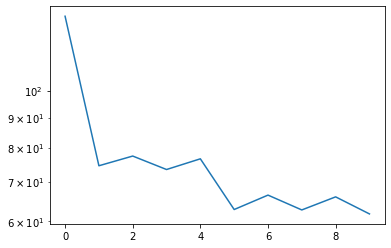

In [43]:
plt.semilogy(loss)

In [44]:
ga_optim.update_population(population)

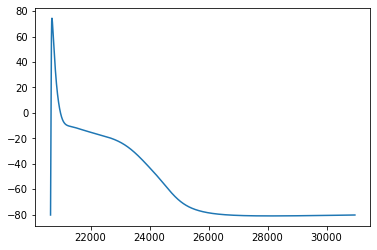

In [45]:
plt.plot(min(population)['phenotype']['1032'].V)